# Acute Myeloid Leukemia (AML) Case Study

This notebook explores a **real-world gene expression dataset** centered on **Acute Myeloid Leukemia (AML)**. The data originates from [Warnat-Herresthal et al. (2020)](https://doi.org/10.1016/j.isci.2019.100780), *"Scalable prediction of acute myeloid leukemia using high-dimensional machine learning and blood transcriptomics."* The dataset includes **log2-transformed, normalized gene expression values** for over **12,000 genes**, measured across a broad and heterogeneous collection of patient samples. These include:

* **AML patients**
* Patients with other **leukemia subtypes** (e.g., CLL, CML, ALL, MDS)
* **Healthy individuals**
* Individuals with **non-leukemic diseases**

Gene expression profiling was performed using both **Affymetrix microarrays (HG-U133A and HG-U133 2.0)** and **RNA-seq** technologies. In this case study, we focus specifically on the **RNA-seq dataset**, which offers higher resolution and broader coverage.

### Objectives of this notebook

* Load and inspect the **RNA-seq AML dataset**
* Preprocess and clean the data
* Perform **exploratory data analysis (EDA)** to examine sample distributions, class balance, and potential confounding factors

In [11]:
# Load the required packages
import sys
import pickle

import numpy as np
import pandas as pd

from collections import Counter

sys.path.append('./')
import utils

In [12]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)

## Data Loading

The original AML datasets are provided within a Docker image made publicly available by the authors of [Warnat-Herresthal et al. (2020)](https://doi.org/10.1016/j.isci.2019.100780). To extract and prepare the datasets for use in Python, follow these steps:

1. **Pull the Docker image** containing the bundled data:

   ```bash
   docker pull schultzelab/aml_classifier:0.1
   ```

2. **Run the image interactively**:

   ```bash
   docker run --name aml_it -it schultzelab/aml_classifier:0.1 bash
   ```

3. **Copy the datasets from the Docker container to your local machine**:

   ```bash
   docker cp aml_it:/data ./ 
   ```

4. **Extract individual datasets from the RData files**:

   * Open the `.RData` files in **R**.
   * Convert the datasets (e.g., `dataset1`, `dataset2`, etc.) to CSV format for compatibility with Python:

     ```r
     write.csv(dataset1, file = "AML_data_1.csv", row.names = FALSE)
     ```

After completing these steps, you can load the exported CSV files in Python.


## Data Processing

In this step, we prepare the RNA-Seq dataset by merging normalized log₂-transformed gene expression values with the corresponding sample metadata, including disease type, tissue source, and study ID. Data cleaning is performed to resolve inconsistencies in categorical fields (e.g., tissue labels, disease names), and relevant columns are cast to categorical types to support efficient visualization and modeling.

The goal of this case study is to predict leukemia (cancer) vs. non-leukemia (non-cancer). To this end, all samples diagnosed with AML, ALL, T.ALL, CLL, CML, or MDS are labeled as Cancer, while all other samples—including healthy individuals or those with unrelated diseases—are labeled as Control.

This clean, annotated dataset is saved as a pickle file and serves as the foundation for subsequent exploratory analysis, predictive modeling, and explainability workflows.

In [13]:
# Define the leukemia types
leukemia_types = ["AML", "ALL", "T.ALL", "CLL", "CML", "MDS"]

In [14]:
# Load metadata and labels
dataset3_info = pd.read_csv("./data/AML_data_3_info.csv")

# Load features
dataset3_features = pd.read_csv("./data/AML_data_3.csv.zip", compression='zip', index_col="sample_id")
dataset3_features = dataset3_features.T
dataset3_features["sample_id"] = dataset3_features.index
dataset3_features.reset_index(inplace=True, drop=True)

# Merge labels and features by sample id
dataset3 = pd.merge(dataset3_features, dataset3_info, on="sample_id", how = "inner")
dataset3.drop(["FAB", "Filename"], axis=1, inplace=True)

# Fix some naming issues
dataset3.loc[dataset3['Tissue'] == ' IgA (Bergers) PBMC', 'Tissue'] = "PBMC"
dataset3.loc[dataset3['Tissue'] == ' IgA (Bergers)PBMC', 'Tissue'] = "PBMC"
dataset3.loc[dataset3['Tissue'] == ' PBMC', 'Tissue'] = "PBMC"
dataset3.loc[dataset3['Disease'] == 'healthy', 'Disease'] = "Healthy"
dataset3.loc[dataset3['Disease'] == 'influenca vaccination', 'Disease'] = "Influenca vaccination"

dataset3[["Condition", "Disease", "GSE", "sample_id", "Tissue"]] = dataset3[["Condition", "Disease", "GSE", "sample_id", "Tissue"]].astype("category")
dataset3['Condition'] = dataset3['Condition'].map({"CONTROL": '0_Control', "CASE": '1_Cancer'})
dataset3.sort_values(by=["Disease", "GSE"], inplace=True)

# Replace condition with "1_cancer" if disease is in leukemia_types
dataset_leukemia = dataset3.copy()
dataset_leukemia["Condition"] = dataset_leukemia.apply(
    lambda row: "1_Cancer" if row["Disease"] in leukemia_types else row["Condition"],
    axis=1,
)
dataset_leukemia.head()

,PAX8,CCL5,MMP14,DTX2P1-UPK3BP1-PMS2P11,BAD,PRPF8,CAPNS1,RPL35,EIF4G2,EIF3D,...,ACTB,GAPDH,MIR3648-2,MIR3648-1,sample_id,Dataset,GSE,Condition,Disease,Tissue
55,429.141908,679.596678,46.224306,937.959260,1608.761060,27720.632747,12820.855077,13999.225407,30957.224082,14112.165495,...,207249.750988,265747.017753,17.718712,17.718712,GSM1202460,3,Simon (GSE49601),1_Cancer,ALL,PBMC
56,342.484974,770.785271,184.880818,2558.886562,1188.066680,24220.254267,12869.839728,13935.471198,18645.105479,10982.375835,...,91774.333718,38670.101249,17.562749,17.562749,GSM1202461,3,Simon (GSE49601),1_Cancer,ALL,BM
57,346.029244,178.616938,119.287279,1148.201355,697.178980,18303.955572,7988.833487,4892.082001,28528.632335,8830.426446,...,158699.288796,82700.438196,6.077328,6.077328,GSM1202462,3,Simon (GSE49601),1_Cancer,ALL,PBMC
58,273.100560,105.789293,51.844630,857.681016,534.301040,13737.032555,4964.479248,21213.436597,20873.148863,7660.995693,...,81507.355855,113369.609393,1.480776,1.480776,GSM1202463,3,Simon (GSE49601),1_Cancer,ALL,BM
59,219.733952,815.029434,43.389352,951.904754,349.511528,13659.251313,4370.811721,7804.724654,38471.198612,5333.294820,...,69913.344447,50200.238258,3.196909,3.196909,GSM1202464,3,Simon (GSE49601),1_Cancer,ALL,BM


In [15]:
with open(f'./data/dataset_leukemia.pickle', 'wb') as handle:
    pickle.dump(dataset_leukemia, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Exploratory Data Analysis

Before developing predictive models, we conduct an **exploratory data analysis (EDA)** to gain a deeper understanding of the dataset’s composition, structure, and potential sources of bias. This step is critical for **identifying confounding factors**, ensuring **model robustness**, and improving **interpretability**.

Specifically, we aim to:

* **Assess class distribution**:
  We evaluate the frequency of each target class (e.g., control vs. cancer) to determine if the dataset is imbalanced. Class imbalance can skew model performance and lead to misleading conclusions.

* **Inspect metadata distributions**:
  We examine key metadata attributes such as:

  * **Tissue type** (e.g., bone marrow, PBMC),
  * **Study origin** (GEO accession numbers), and
  * **Disease subtype** (e.g., AML, CLL, CML, MDS)
    to understand the diversity and representation of biological and technical conditions in the dataset.

* **Visualize potential batch effects**:
  Using dimensionality reduction techniques like PCA and UMAP, we project the high-dimensional gene expression space into two dimensions. Coloring by metadata features (e.g., study or tissue) helps identify patterns that may reflect batch effects or non-biological variation.

* **Check for feature variability and missing values**:
  Although the dataset is already normalized and cleaned, it’s important to confirm the absence of missing values and assess the overall variance of gene expression across samples.

Through this EDA, we aim to ensure that our downstream analyses and model interpretations are not biased by hidden structure in the data and that **biological signals**, not technical artifacts, drive the patterns we uncover.

In [16]:
print(f"Number of missing values in the dataset: {sum(dataset_leukemia.isnull().sum())}")
print(f"Number of genes in the dataset: {dataset_leukemia.shape[1]}")
print(f"Number of studies in the dataset: {len(Counter(dataset_leukemia["GSE"]))}")
print(f"Number of disease types in the dataset: {len(Counter(dataset_leukemia["Disease"]))}")

Number of missing values in the dataset: 0
Number of genes in the dataset: 12714
Number of studies in the dataset: 23
Number of disease types in the dataset: 31


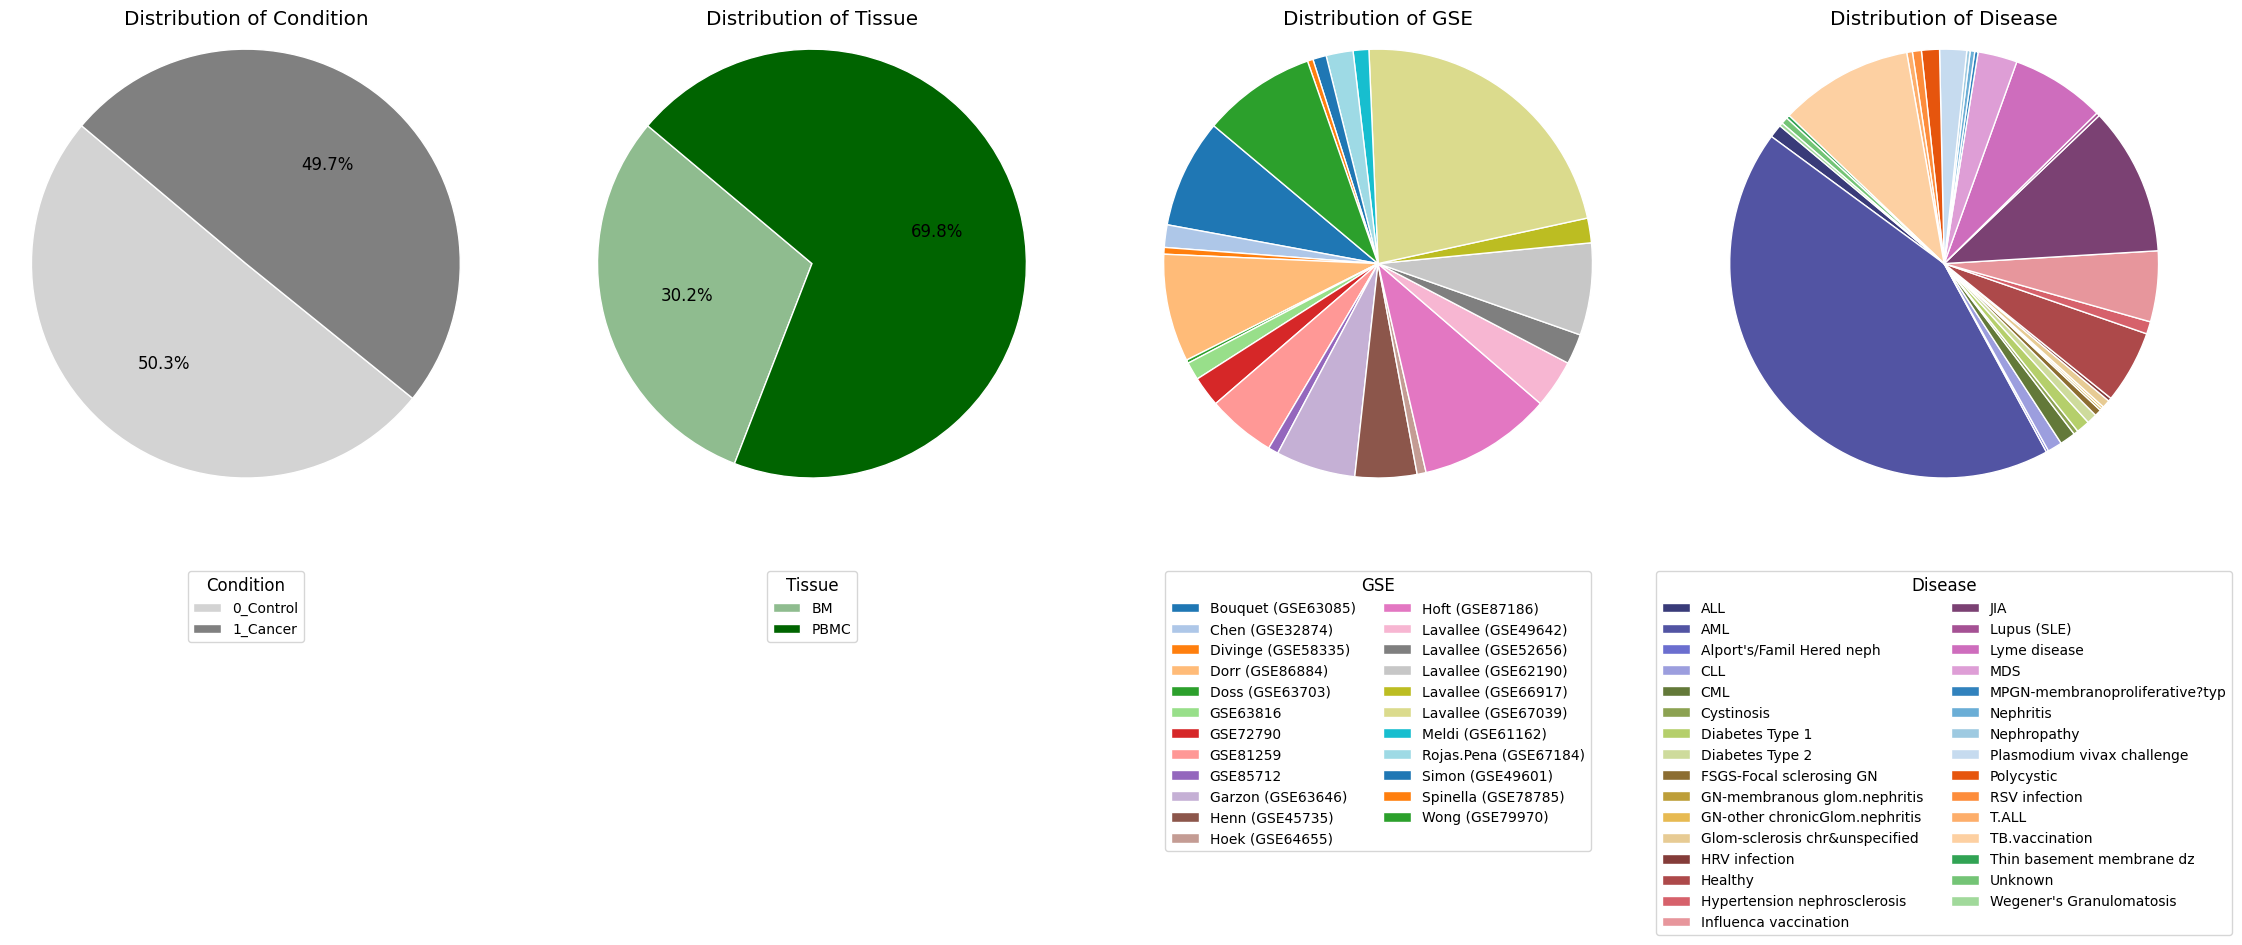

In [17]:
utils.plot_pie_charts(dataset_leukemia, name="case_study_2")

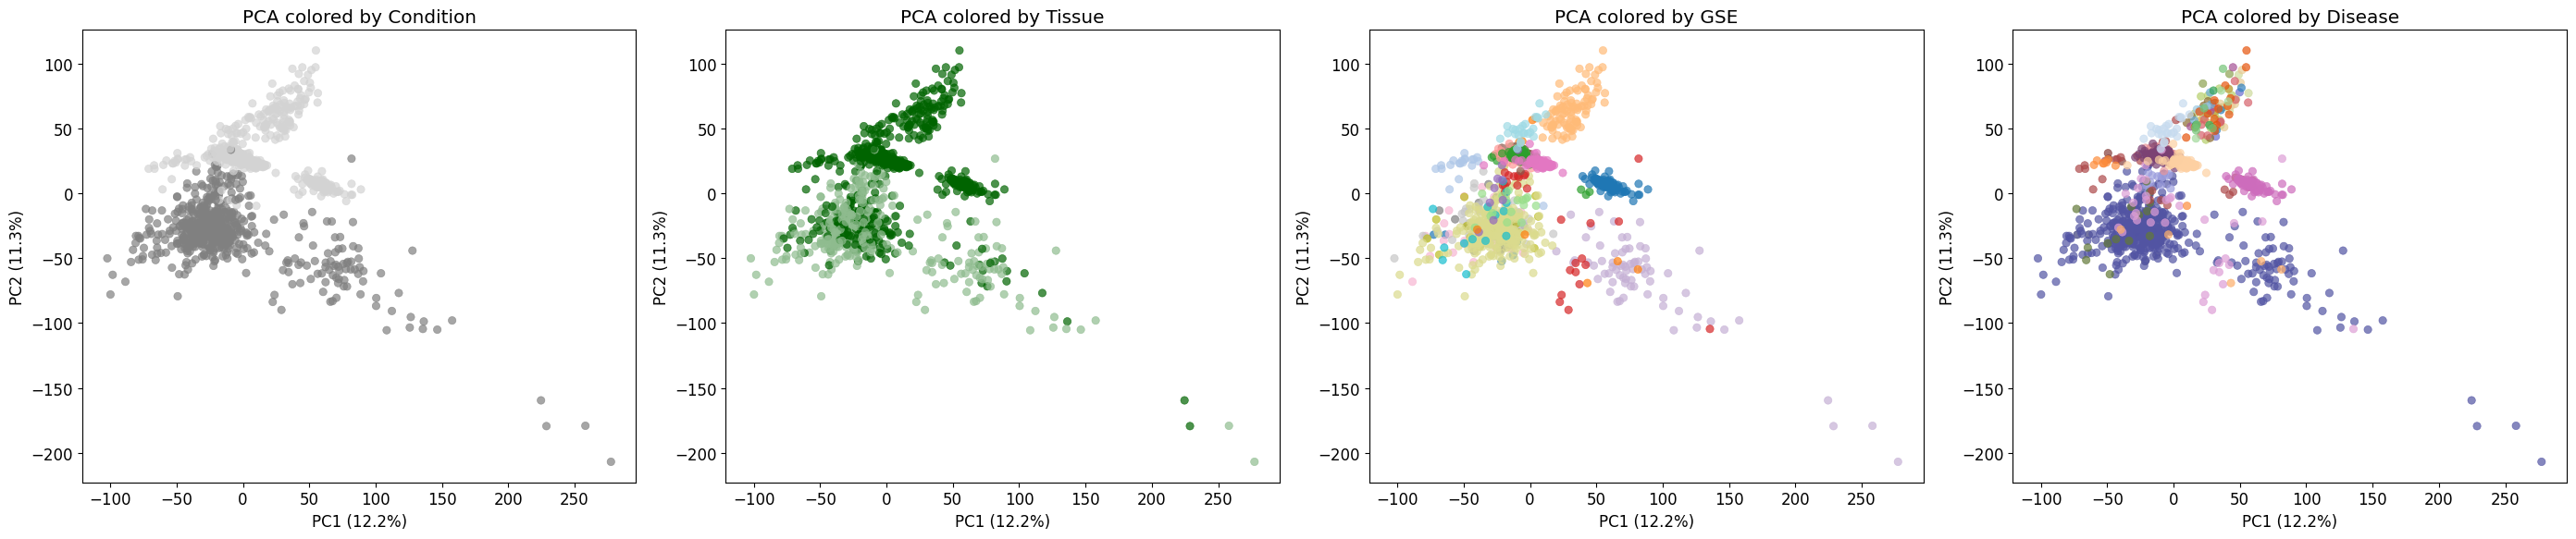

In [18]:
utils.plot_pca(dataset_leukemia, name="case_study_2")

/opt/anaconda3/envs/fgc/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


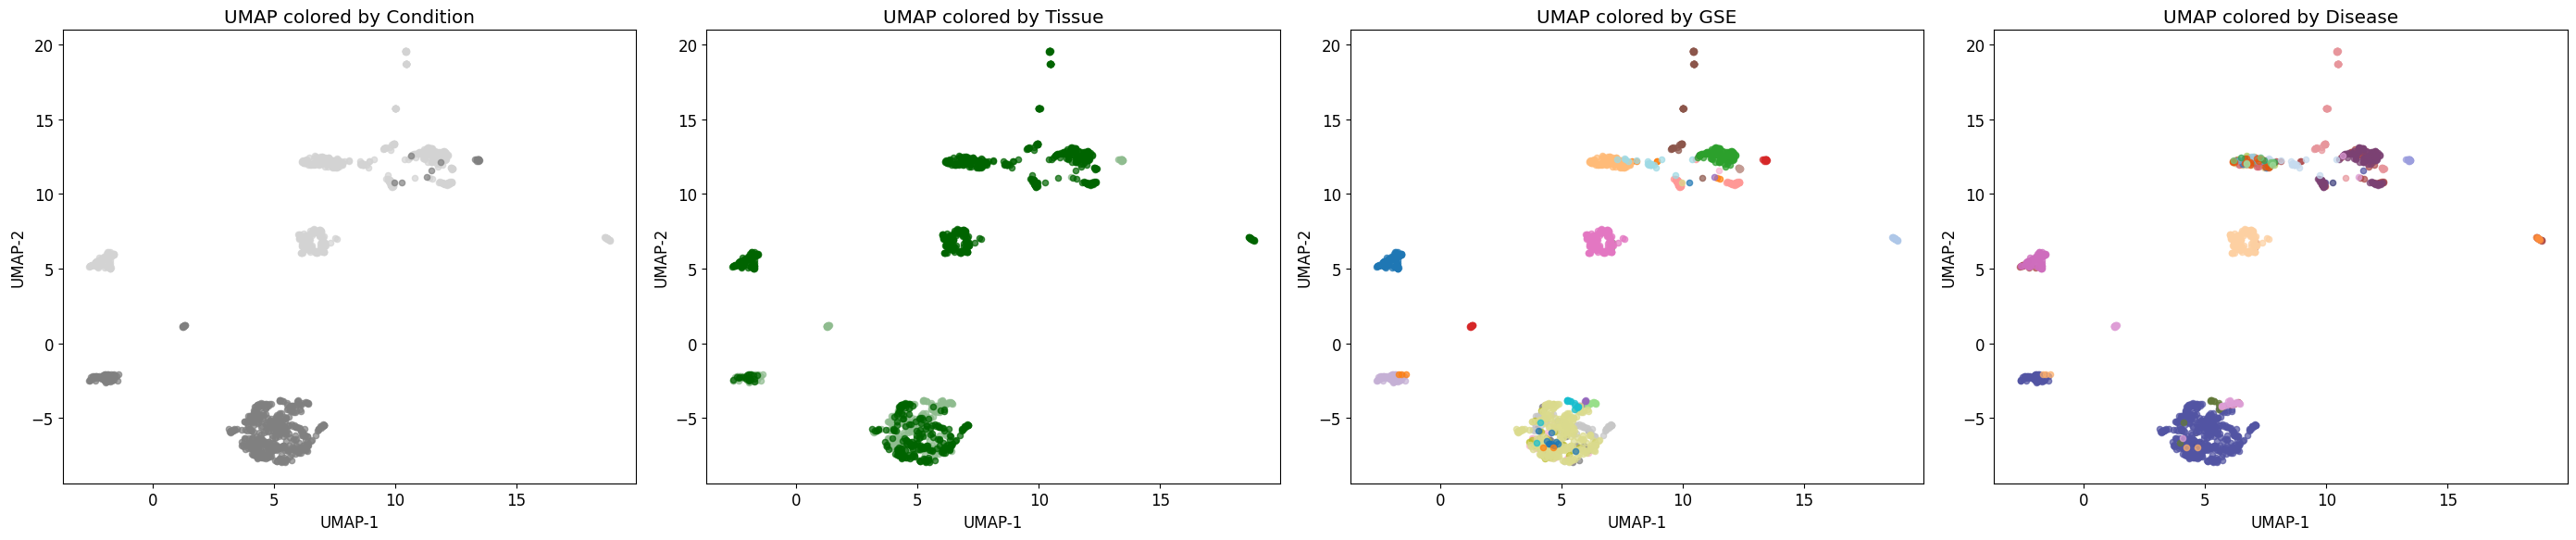

In [19]:
utils.plot_umap(dataset_leukemia, name="case_study_2")

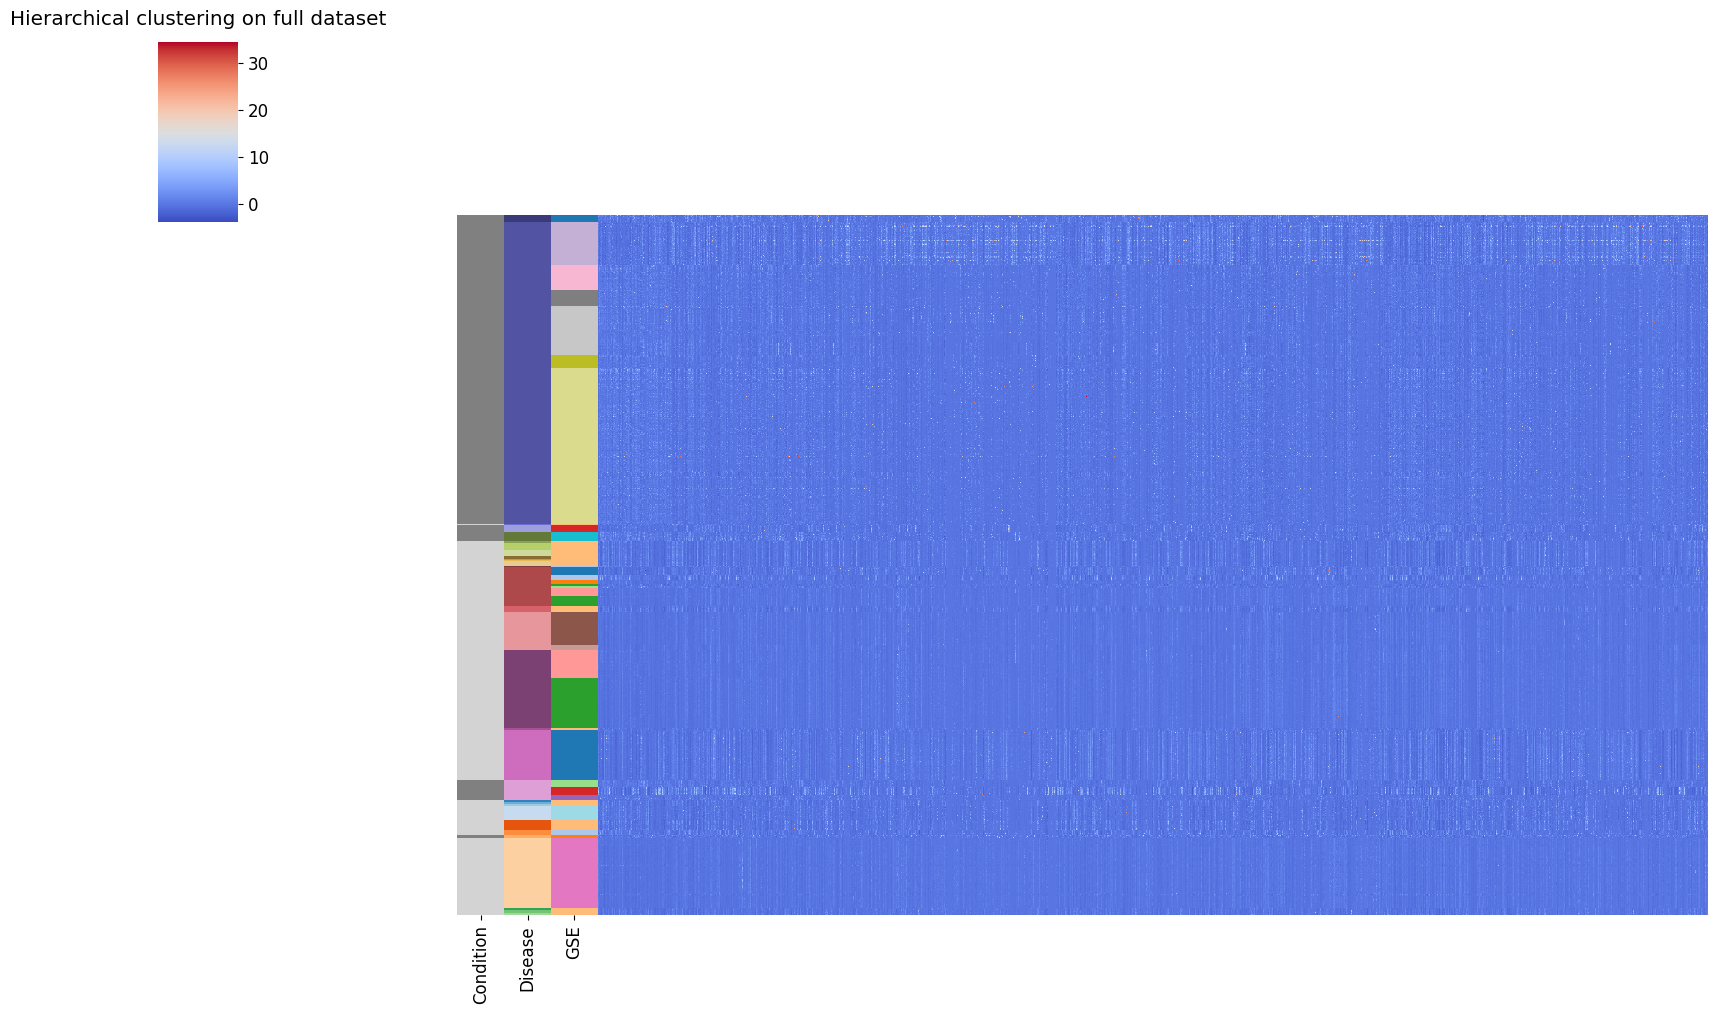

In [20]:
utils.hierarchical_clustering_heatmap(dataset_leukemia, name="case_study_2")

## Conclusion

The exploratory analysis of the RNA-Seq dataset reveals important insights regarding the composition, structure, and potential biases in the data:

* **Class Balance**: The pie chart shows a nearly balanced class split, with \~50.3% control (non-leukemia) and \~49.7% cancer (including AML and other leukemias) samples. 

* **Tissue Distribution**: The dataset is dominated by **PBMC-derived samples (\~70%)**, with bone marrow (BM) samples making up the rest. This asymmetry suggests that tissue source may be a potential confounding variable influencing gene expression profiles.

* **Study Origin (GSE)**: The data is pooled from **over 20 independent studies**, each potentially introducing its own batch effects. This diversity requires attention when assessing model generalizability across cohorts.

* **Disease Diversity**: A wide range of disease types are represented, including multiple leukemia subtypes (AML, ALL, T.ALL, CML, CLL, MDS) and non-leukemic diseases. 

* **UMAP & PCA Projections**: Both dimensionality reduction methods reveal distinct sample groupings by metadata categories. In particular, samples cluster tightly when colored by `Condition`, `Tissue`, and `Disease`, indicating that gene expression patterns are structured both biologically and technically.

* **Hierarchical Clustering**: The heatmap shows block-wise co-expression patterns that align with metadata labels. Samples from similar disease types or the same study tend to group together.

Together, these findings validate the presence of meaningful biological structure in the gene expression space but also highlight the need for careful modeling. In particular, **tissue type and study origin may act as confounders** and must be considered during training and interpretation.